# BN, HBN, SBN uncertainty on CIFAR5

In [1]:
%env CUDA_VISIBLE_DEVICES=3

import torch
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import sys
sys.path.append('./StochBN/')

from utils import *


%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=3


In [2]:
cifar5_train, cifar5_test = get_dataloader(data='cifar5', test_bs=500)
cifar5rest_train, cifar5rest_test = get_dataloader(data='cifar5-rest', test_bs=500)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [36]:
net_hbn = load_model('vgg-exps/cifar5/bn-my/bs4/best_model')
net_sbn = load_model('vgg-exps/cifar5/sbn')

set_bn_mode(net_sbn, mode='StochBN')
set_bn_mode(net_hbn, 'StochBN')

In [61]:
hbn_bn = []
sbn_bn = []

for m in net_hbn.modules():
    if isinstance(m, MyBatchNorm2d):
        hbn_bn.append(m)
        
for m in net_sbn.modules():
    if isinstance(m, MyBatchNorm2d):
        sbn_bn.append(m)

## SNR distributions for layers

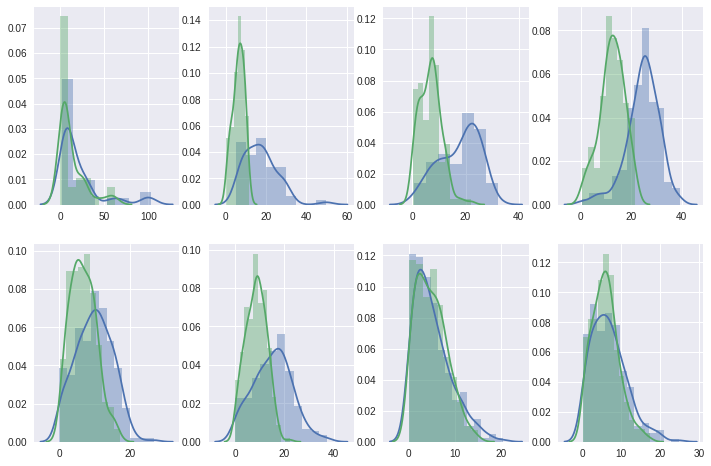

In [66]:
plt.figure(figsize=(12, 8))
for i, [hbn, sbn] in enumerate(zip(hbn_bn, sbn_bn)):
    plt.subplot(2, 4, i + 1)
    sns.distplot((torch.abs(hbn.running_mean_mean) / torch.sqrt(hbn.running_mean_var)).cpu().numpy());
    sns.distplot((torch.abs(sbn.running_mean_mean) / torch.sqrt(sbn.running_mean_var)).cpu().numpy());

-----

## Uncertainty

In [15]:
sbn_res = {}
hbn_res = {}
bn_res = {}


for bs in bs_grid:    
    net_hbn = load_model('vgg-exps/cifar5/bn-my/bs{}/best_model'.format(bs))
#     net_bn = load_model('vgg-exps/cifar5/bn-my/bs{}/best_model'.format(bs))
    net_sbn = load_model('vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/best_model'.format(bs))
    net_hbn.eval()
    net_sbn.eval()
#     net_bn.eval()
    
    set_bn_mode(net_sbn, mode='StochBN')
    set_bn_mode(net_hbn, 'StochBN')
#     set_bn_mode(net_bn, 'StochBN')

    sbn_res[bs] = uncertainty_acc(net_sbn, cifar5_test, cifar5rest_test)
    hbn_res[bs] = uncertainty_acc(net_hbn, cifar5_test, cifar5rest_test)
    bn_res[bs] = uncertainty_acc(net_hbn, cifar5_test, cifar5rest_test, 
                                 vanilla_known=(cifar5_test.dataset.test_data, cifar5_test.dataset.test_labels),
                                 vanilla_unknown=(cifar5rest_test.dataset.test_data, cifar5rest_test.dataset.test_labels),
                                 bn_type='BN', bs=bs)




/home/andrew/anaconda2/lib/python2.7/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'models.stochbn.MyBatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [16]:
torch.save({'bn': bn_res, 'sbn': sbn_res, 'hbn': hbn_res}, 'bn_types_uncertainty')

### Accuracy 

In [40]:
for bs in bs_grid:
    print('\nbatch size {}'.format(bs))
    print('  EVAL   -- BN {:.3f}, HBN {:.3f}, SBN {:.3f}'.format(bn_res[bs][1]['eval/acc'],
                                                                 hbn_res[bs][1]['eval/acc'],
                                                                 sbn_res[bs][1]['eval/acc']))


    print('ENSEMBLE -- BN {:.3f}, HBN {:.3f}, SBN {:.3f}'.format(bn_res[bs][1]['ensemble/acc'],
                                                                 hbn_res[bs][1]['ensemble/acc'],
                                                                 sbn_res[bs][1]['ensemble/acc']))
    
    print('ONE SHOT -- BN {:.3f}, HBN {:.3f}, SBN {:.3f}'.format(bn_res[bs][1]['one_shot/acc'],
                                                                 hbn_res[bs][1]['one_shot/acc'],
                                                                 sbn_res[bs][1]['one_shot/acc']))


batch size 4
  EVAL   -- BN 0.930, HBN 0.930, SBN 0.925
ENSEMBLE -- BN 0.931, HBN 0.929, SBN 0.918
ONE SHOT -- BN 0.926, HBN 0.908, SBN 0.889

batch size 8
  EVAL   -- BN 0.937, HBN 0.937, SBN 0.933
ENSEMBLE -- BN 0.938, HBN 0.934, SBN 0.934
ONE SHOT -- BN 0.931, HBN 0.921, SBN 0.917

batch size 16
  EVAL   -- BN 0.934, HBN 0.934, SBN 0.931
ENSEMBLE -- BN 0.934, HBN 0.934, SBN 0.930
ONE SHOT -- BN 0.930, HBN 0.924, SBN 0.917

batch size 32
  EVAL   -- BN 0.934, HBN 0.934, SBN 0.934
ENSEMBLE -- BN 0.932, HBN 0.934, SBN 0.933
ONE SHOT -- BN 0.926, HBN 0.926, SBN 0.920

batch size 128
  EVAL   -- BN 0.932, HBN 0.932, SBN 0.929
ENSEMBLE -- BN 0.931, HBN 0.932, SBN 0.929
ONE SHOT -- BN 0.928, HBN 0.930, SBN 0.928


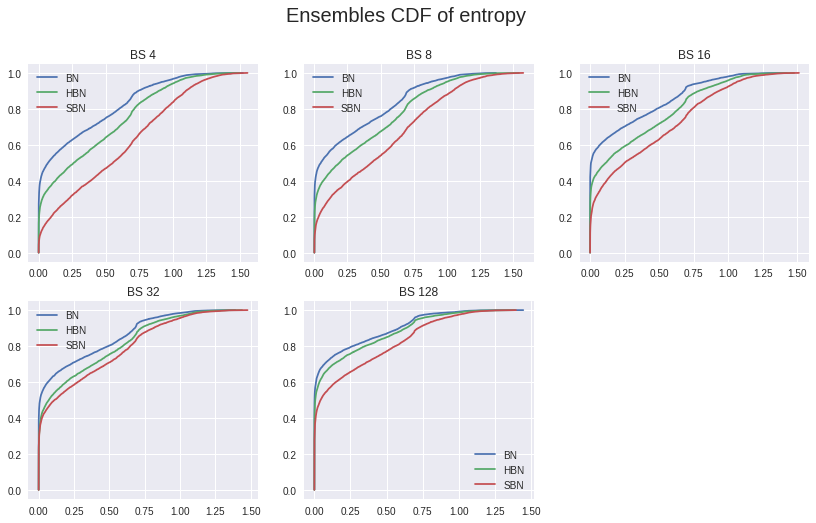

In [37]:
plt.figure(figsize=(14, 8))

plt.suptitle('Ensembles CDF of entropy', size=20)
for i, [c, bs] in enumerate(zip(colors, bs_grid)):
    plt.subplot(2, 3, i + 1)
    plt.title('BS {}'.format(bs))
    ent = bn_res[bs][0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, label='BN'.format(bs))

    ent = hbn_res[bs][0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, label='HBN')

    ent = sbn_res[bs][0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, label='SBN')

    plt.legend()

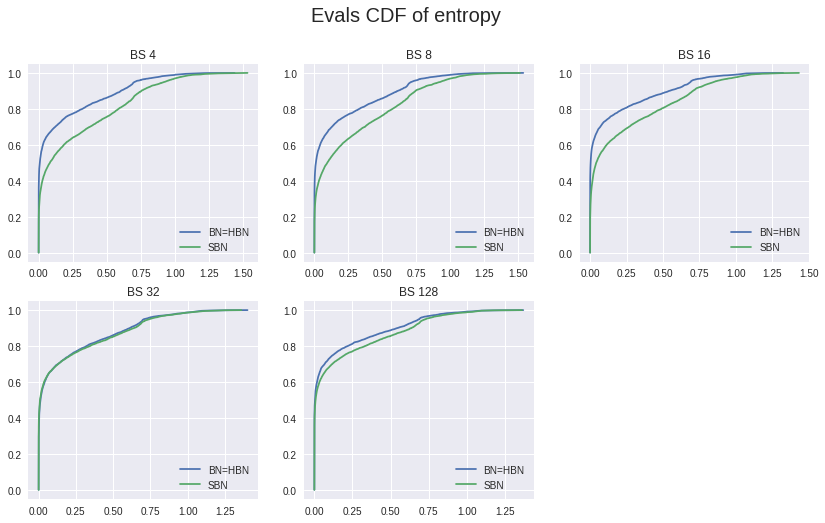

In [39]:
plt.figure(figsize=(14, 8))
plt.suptitle('Evals CDF of entropy', size=20)
for i, [c, bs] in enumerate(zip(colors, bs_grid)):
    plt.subplot(2, 3, i + 1)
    plt.title('BS {}'.format(bs))
    ent = bn_res[bs][0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, label='BN=HBN'.format(bs))

#     ent = hbn_res[bs][0]['eval/entropy']
#     n = len(ent)
#     plt.plot(sorted(ent), (np.arange(n) + 1.) / n, label='HBN=BN')

    ent = sbn_res[bs][0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, label='SBN')

    plt.legend()